In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn import metrics
from scipy.stats import spearmanr, pearsonr
import warnings
warnings.filterwarnings('ignore')

# Data Exploration

In [2]:
# Load the data.
dataset = pd.read_csv('merged_data/merged_data.csv')
dataset

,Unnamed: 0,Brand,Model,mass,wheel_base,axle_width_steering,axle_width_other,engine_cap,engine_pow,co2_wltp,CO2
0,0,Alfa Romeo,Giulia,1620.0,2820.0,1556.0,1629.0,1995.0,206.0,184.0,182.051282
1,1,Alfa Romeo,Giulia,1640.0,2820.0,1556.0,1629.0,2143.0,154.0,145.0,182.051282
2,2,Alfa Romeo,Giulia,1570.0,2820.0,1571.0,1641.0,2143.0,140.0,133.0,182.051282
3,3,Alfa Romeo,Giulia,1640.0,2820.0,1556.0,1629.0,2143.0,154.0,141.0,182.051282
4,4,Alfa Romeo,Giulia,1570.0,2820.0,1571.0,1641.0,2143.0,140.0,128.0,182.051282
...,...,...,...,...,...,...,...,...,...,...,...
214853,11805865,Volvo,Xc90,2210.0,2984.0,1674.0,1674.0,1969.0,173.0,184.0,249.122807
214854,11805868,Volvo,Xc90,2181.0,2984.0,1674.0,1674.0,1969.0,173.0,171.0,249.122807
214855,11805875,Volvo,Xc90,2211.0,2984.0,1674.0,1674.0,1969.0,173.0,185.0,249.122807
214856,11805882,Volvo,Xc90,2206.0,2984.0,1666.0,1666.0,1969.0,173.0,199.0,249.122807


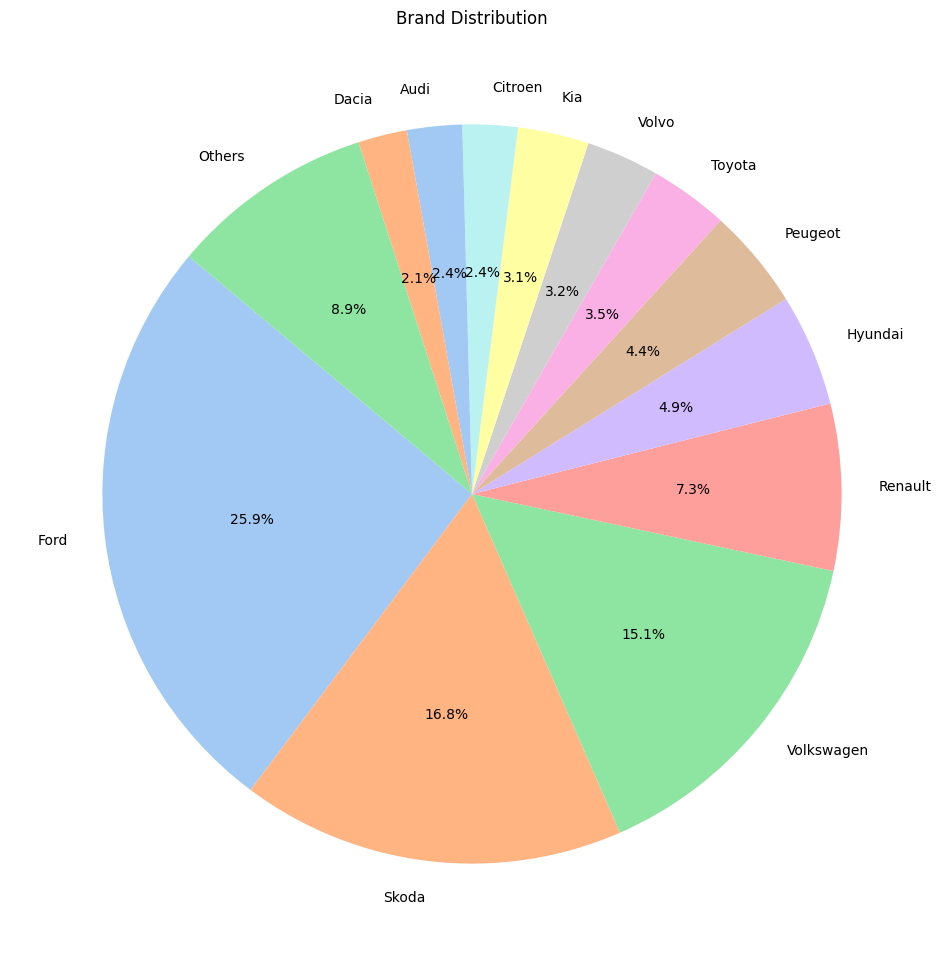

In [3]:
# Number of each brand.
brand_nums = dataset['Brand'].value_counts()

# Calculate the percentage
total_brands = len(dataset['Brand'])
brand_percentages = brand_nums / total_brands * 100

# Identify brands with less than 2% and combine them into 'Others'
threshold = 2
mask = brand_percentages >= threshold
filtered_brands = brand_percentages[mask]
filtered_brands['Others'] = brand_percentages[~mask].sum()

# Plot the pie chart
plt.figure(figsize=(12, 12))
plt.pie(filtered_brands, labels=filtered_brands.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Brand Distribution')
plt.show()

In [4]:
# We need to see the data types of columns to see if do we need to convert their types.
print (dataset.dtypes)
# "Brand" and "Model" will not be used for training the model. So, we need to drop these columns.

Unnamed: 0               int64
Brand                   object
Model                   object
mass                   float64
wheel_base             float64
axle_width_steering    float64
axle_width_other       float64
engine_cap             float64
engine_pow             float64
co2_wltp               float64
CO2                    float64
dtype: object


In [5]:
dataset.drop(columns=["Brand","Model","Unnamed: 0"],inplace= True)
print (dataset.dtypes)
# All columns have numeric values.

mass                   float64
wheel_base             float64
axle_width_steering    float64
axle_width_other       float64
engine_cap             float64
engine_pow             float64
co2_wltp               float64
CO2                    float64
dtype: object


# Data Cleaning

**Fill in missing values**

In [6]:
dataset.isnull().sum()
# There is no missing values, so we do not need to do filling.

mass                   0
wheel_base             0
axle_width_steering    0
axle_width_other       0
engine_cap             0
engine_pow             0
co2_wltp               0
CO2                    0
dtype: int64

In [7]:
# There may be some columns that has same value for every row.
columns_to_remove = []
for column in dataset.columns:
    if dataset[column].nunique() == 1:
        columns_to_remove.append(column)

print(columns_to_remove)
# There is no such case in this dataset. So, we did not remove any column.

[]


**Identify outliers and smooth out noisy data**

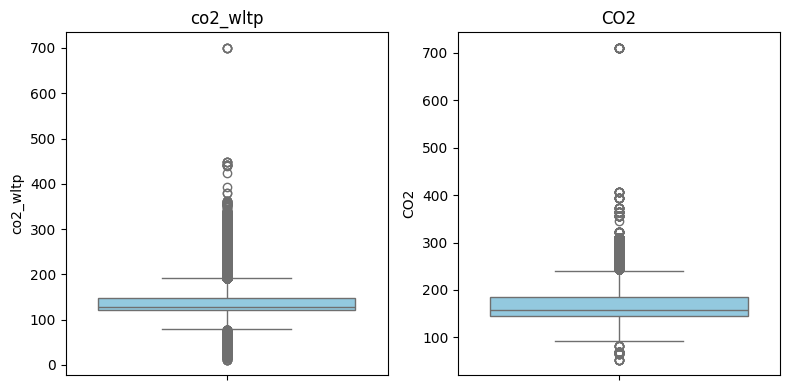

In [8]:
# Lets see the boxplot graphs of "co2_wltp" and "CO2" to visualize outliers.
# We did not considered other features, because they are about vehicle specific.
plt.figure(figsize=(8, 4))
i = 1
for column in ["co2_wltp","CO2"]:
    plt.subplot(1, 2,i)  
    i+=1
    sns.boxplot(data=dataset, y=column, color='skyblue')
    plt.title(column)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
# As we can see, there are outliers value for higher than 500, so we need to drop them.

In [9]:
print("Before outlier detection shape of data is :",dataset.shape)
dataset = dataset[dataset['CO2'] <= 500]
dataset = dataset[dataset['co2_wltp'] <= 500]
print("After outlier detection shape of data is :",dataset.shape)
# 15 samples removed due to outlier detection.

Before outlier detection shape of data is : (214858, 8)
After outlier detection shape of data is : (214843, 8)


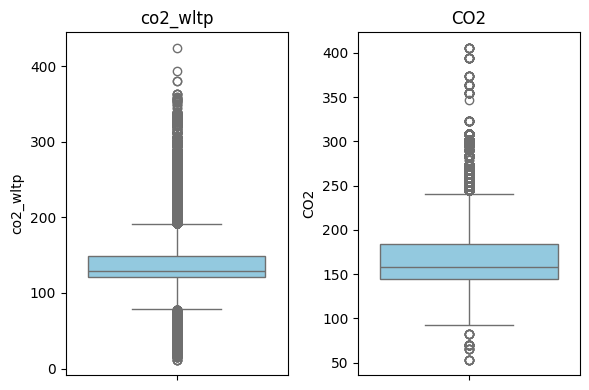

In [10]:
plt.figure(figsize=(6, 4))
i = 1
for column in ["co2_wltp","CO2"]:
    plt.subplot(1, 2,i)  
    i+=1
    sns.boxplot(data=dataset, y=column, color='skyblue')
    plt.title(column)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
# As we cann see, outliers are gone.

In [11]:
# Lets see the statistical values of all features after outlier extraction.
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
mass,214843.0,1520.026052,293.916037,750.000000,1352.000000,1451.000000,1618.000000,4427.000000
wheel_base,214843.0,2720.789311,199.746500,600.000000,2640.000000,2690.000000,2785.000000,4490.000000
axle_width_steering,214843.0,1568.129695,93.481304,530.000000,1535.000000,1566.000000,1581.000000,3000.000000
axle_width_other,214843.0,1564.794650,95.805024,650.000000,1530.000000,1566.000000,1578.000000,3000.000000
engine_cap,214843.0,1540.840823,492.883539,658.000000,999.000000,1498.000000,1968.000000,6749.000000
engine_pow,214843.0,109.145083,38.720124,10.000000,88.000000,103.000000,114.000000,485.000000
co2_wltp,214843.0,137.318270,35.784233,12.000000,121.000000,129.000000,149.000000,424.000000
CO2,214843.0,168.716994,39.221586,53.383459,144.897959,157.777778,184.415584,405.714286


# Distribution

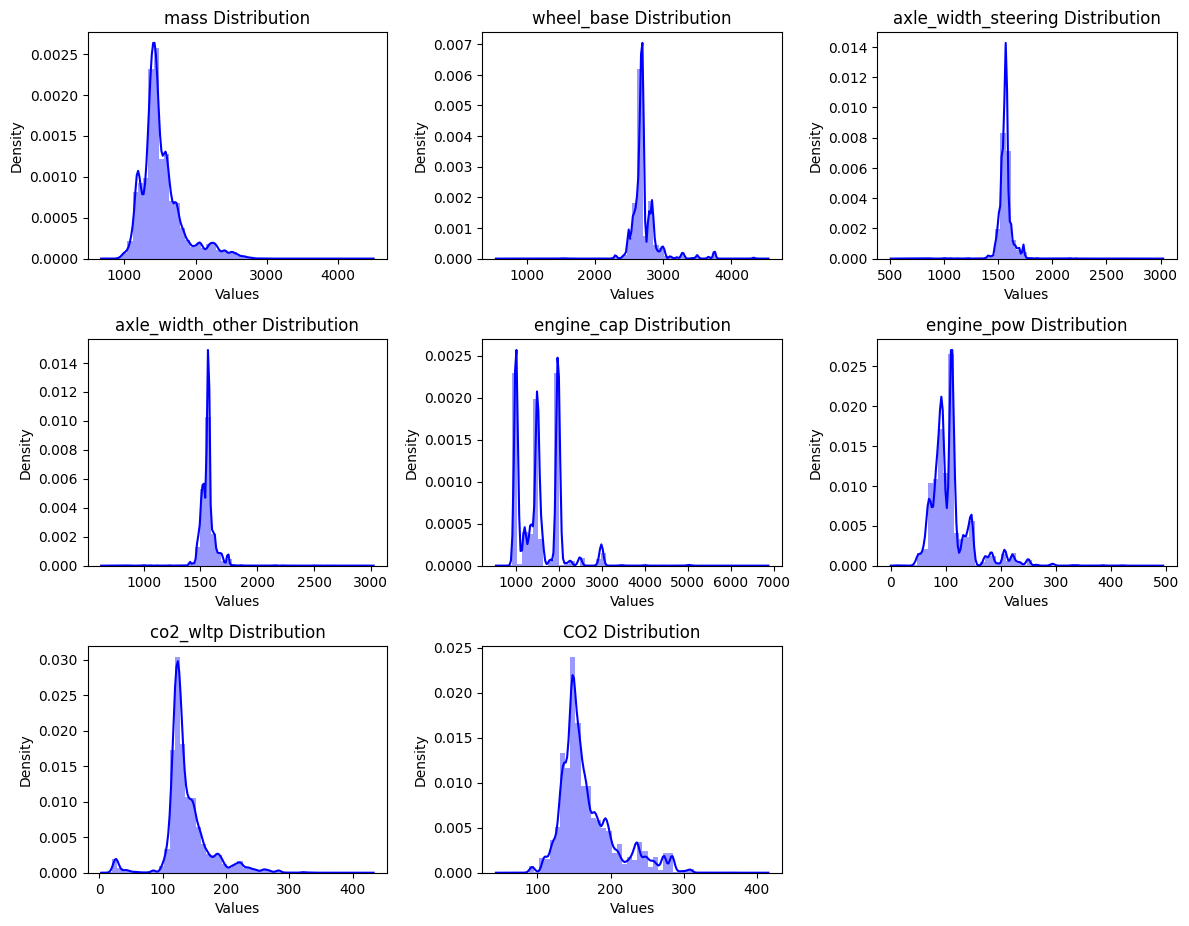

In [12]:
# Distribution of all features.
plt.figure(figsize=(12, 12))  
n_features = len(dataset.columns)
n_rows = (n_features // 3) + (n_features % 3)  
for i, column in enumerate(dataset.columns):
    plt.subplot(n_rows, 3, i + 1) 
    sns.distplot(dataset[column], color='b')
    plt.title(f'{column} Distribution')
    plt.xlabel('Values')

plt.tight_layout()
plt.show()

# Data Transformation

**Normalization**

In [14]:
# "CO2" column will be predicted, so we did not scaled it.
features_to_scale = dataset.drop('CO2', axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_scale)
dataset_scaled = pd.DataFrame(scaled_features, columns=features_to_scale.columns)
dataset_scaled['CO2'] = dataset['CO2']
dataset = dataset_scaled
dataset

,mass,wheel_base,axle_width_steering,axle_width_other,engine_cap,engine_pow,co2_wltp,CO2
0,0.340145,0.496684,-0.129756,0.670168,0.921435,2.501416,1.304537,182.051282
1,0.408192,0.496684,-0.129756,0.670168,1.221710,1.158442,0.214669,182.051282
2,0.170028,0.496684,0.030705,0.795423,1.221710,0.796872,-0.120675,182.051282
3,0.408192,0.496684,-0.129756,0.670168,1.221710,1.158442,0.102887,182.051282
4,0.170028,0.496684,0.030705,0.795423,1.221710,0.796872,-0.260402,182.051282
...,...,...,...,...,...,...,...,...
214838,2.347526,1.317727,1.132532,1.139873,0.868684,1.649144,1.304537,249.122807
214839,2.248858,1.317727,1.132532,1.139873,0.868684,1.649144,0.941247,249.122807
214840,2.350928,1.317727,1.132532,1.139873,0.868684,1.649144,1.332482,249.122807
214841,2.333917,1.317727,1.046953,1.056370,0.868684,1.649144,1.723717,249.122807


In [15]:
dataset.dropna(inplace=True)
dataset.isnull().sum()
# We made sure, data do not contain missing value.

mass                   0
wheel_base             0
axle_width_steering    0
axle_width_other       0
engine_cap             0
engine_pow             0
co2_wltp               0
CO2                    0
dtype: int64

# Feature Selection

**Feature Selection by Strong Correlations**

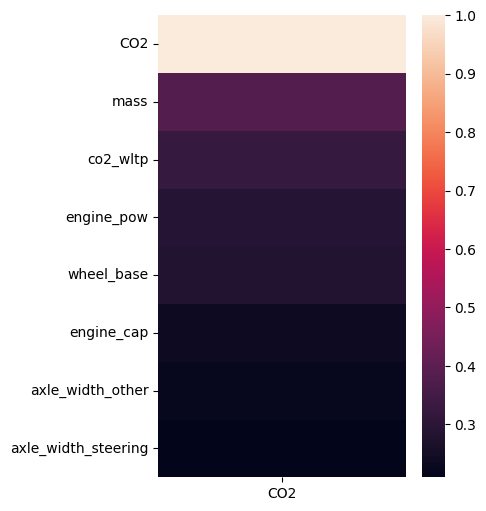

In [17]:
# Correlation graph for the target column.
plt.figure(figsize=(4, 6))
heatmap = sns.heatmap(dataset.corr()[["CO2"]].sort_values(by="CO2",ascending=False))

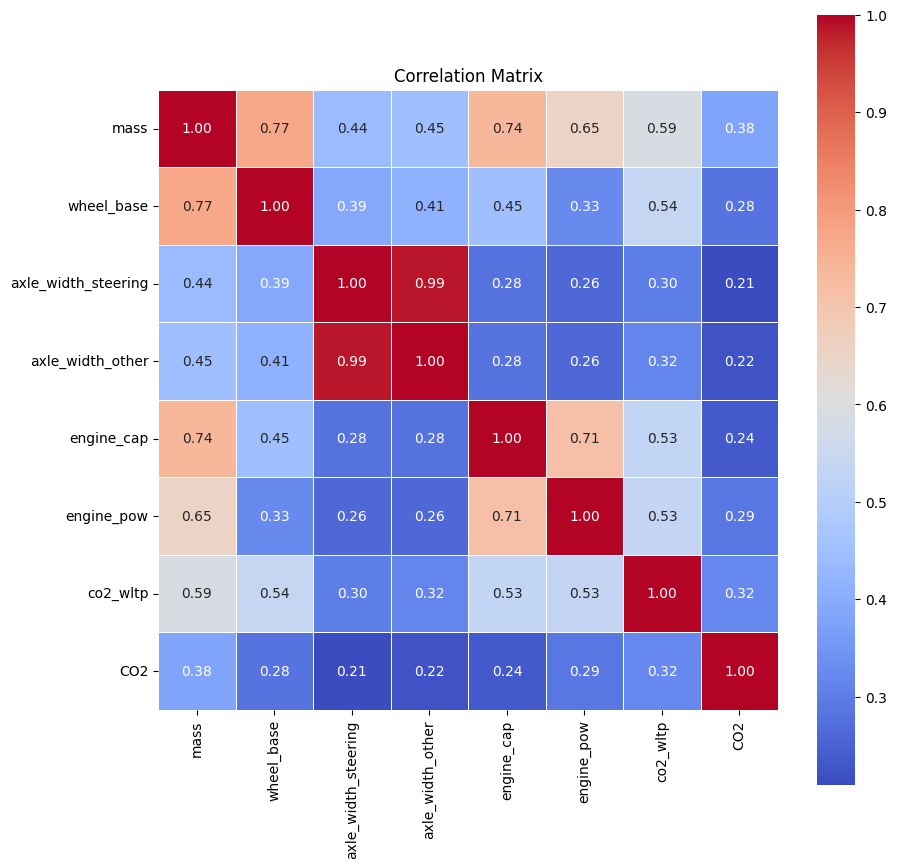

In [18]:
correlation_matrix = dataset.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True,square=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


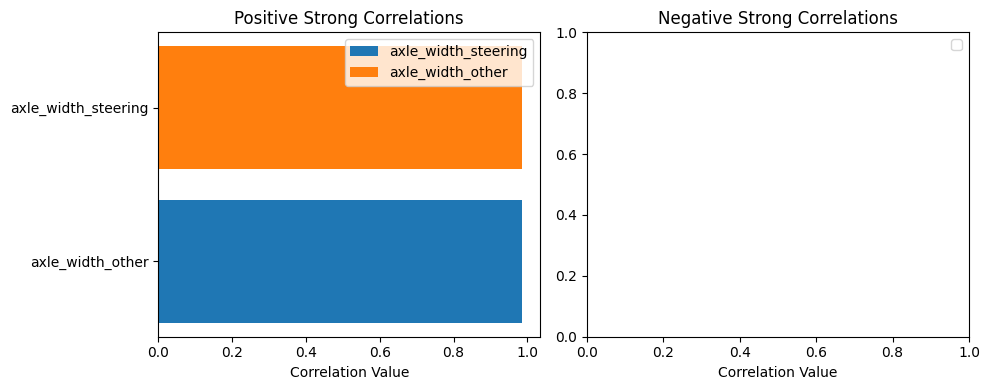

In [19]:
# We set a threshold to decide strong correlations.
positive_strong_threshold = 0.80
negative_strong_threshold = -0.80

positive_strong_correlations_dict = {}
negative_strong_correlations_dict = {}

for column in correlation_matrix.columns:
    strong_corr = correlation_matrix[(correlation_matrix[column] > positive_strong_threshold) & (correlation_matrix[column] < 1)][column]
    if not strong_corr.empty and column != strong_corr.index[0]:  
        positive_strong_correlations_dict[column] = strong_corr.to_dict()

for column in correlation_matrix.columns:
    strong_corr = correlation_matrix[(correlation_matrix[column] < negative_strong_threshold) & (correlation_matrix[column] > -1)][column]
    if not strong_corr.empty and column != strong_corr.index[0]: 
        negative_strong_correlations_dict[column] = strong_corr.to_dict()

# Plot a graph that shows which feature is strongly correlated with which one.
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
for variable, correlations in positive_strong_correlations_dict.items():
    plt.barh(list(correlations.keys()), list(correlations.values()), label=variable)
plt.xlabel('Correlation Value')
plt.title('Positive Strong Correlations')
plt.legend()

plt.subplot(1, 2, 2)
for variable, correlations in negative_strong_correlations_dict.items():
    plt.barh(list(correlations.keys()), list(correlations.values()), label=variable)
plt.xlabel('Correlation Value')
plt.title('Negative Strong Correlations')
plt.legend()

plt.tight_layout()
plt.show()

"axle_width_steering" and "axle_width_other" columns are highly correlated. We need one of them.

In [20]:
# We will keep the only one feature of strong correlations.
features_to_dropped = set()

# Positively correlated features
for feature, corr_dict in positive_strong_correlations_dict.items():
    if feature not in features_to_dropped:
        # Mark correlated features as non-selectable
        for correlated_feature in corr_dict.keys():
            features_to_dropped.add(correlated_feature)

# Negatively correlated features
for feature, corr_dict in negative_strong_correlations_dict.items():
    if feature not in features_to_dropped:
        # Mark correlated features as non-selectable
        for correlated_feature in corr_dict.keys():
            features_to_dropped.add(correlated_feature)

# Remove non-selectable columns from the dataset
feature_selected_data = dataset.drop(columns=features_to_dropped)
dataset = feature_selected_data
dataset
# After feature selection, we reduced the feature size from 8 to 7.

,mass,wheel_base,axle_width_steering,engine_cap,engine_pow,co2_wltp,CO2
0,0.340145,0.496684,-0.129756,0.921435,2.501416,1.304537,182.051282
1,0.408192,0.496684,-0.129756,1.221710,1.158442,0.214669,182.051282
2,0.170028,0.496684,0.030705,1.221710,0.796872,-0.120675,182.051282
3,0.408192,0.496684,-0.129756,1.221710,1.158442,0.102887,182.051282
4,0.170028,0.496684,0.030705,1.221710,0.796872,-0.260402,182.051282
...,...,...,...,...,...,...,...
214838,2.347526,1.317727,1.132532,0.868684,1.649144,1.304537,249.122807
214839,2.248858,1.317727,1.132532,0.868684,1.649144,0.941247,249.122807
214840,2.350928,1.317727,1.132532,0.868684,1.649144,1.332482,249.122807
214841,2.333917,1.317727,1.046953,0.868684,1.649144,1.723717,249.122807


# Model Developing

In [21]:
X = dataset.drop('CO2',axis=1)
y = dataset['CO2'] # target value
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=23)

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
def print_errors(y_test, y_pred):
    # (R²) 
    r2 = metrics.r2_score(y_test, y_pred)
    print(f'R-squared (R²): {r2}')
    # (MAE)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')
    # (MSE)
    mse = metrics.mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')
    # (RMSE)
    rmse = np.sqrt(mse)
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    # Lower MAPE value indicates a better model.
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'MAPE: {mape}%')
    # Pearson Coefficient
    pearson_corr, _ = pearsonr(y_test, y_pred)
    print(f"Pearson Coefficient: {pearson_corr}")
    # Spearman Coefficient
    spearman_corr, _ = spearmanr(y_test, y_pred)
    print(f"Spearman Coefficient: {spearman_corr}")

**Linear Regression**

In [25]:
lin_reg = LinearRegression()
model = lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)

In [26]:
# 0.18 (R²) indicates an average model.
print_errors(y_test, y_pred)

R-squared (R²): 0.1779705811205955
Mean Absolute Error (MAE): 25.324845963501883
Mean Squared Error (MSE): 1264.999902504842
Root Mean Squared Error (RMSE): 35.56683711696673
MAPE: 14.607158314998072%
Pearson Coefficient: 0.4218907352265194
Spearman Coefficient: 0.43147438165547186


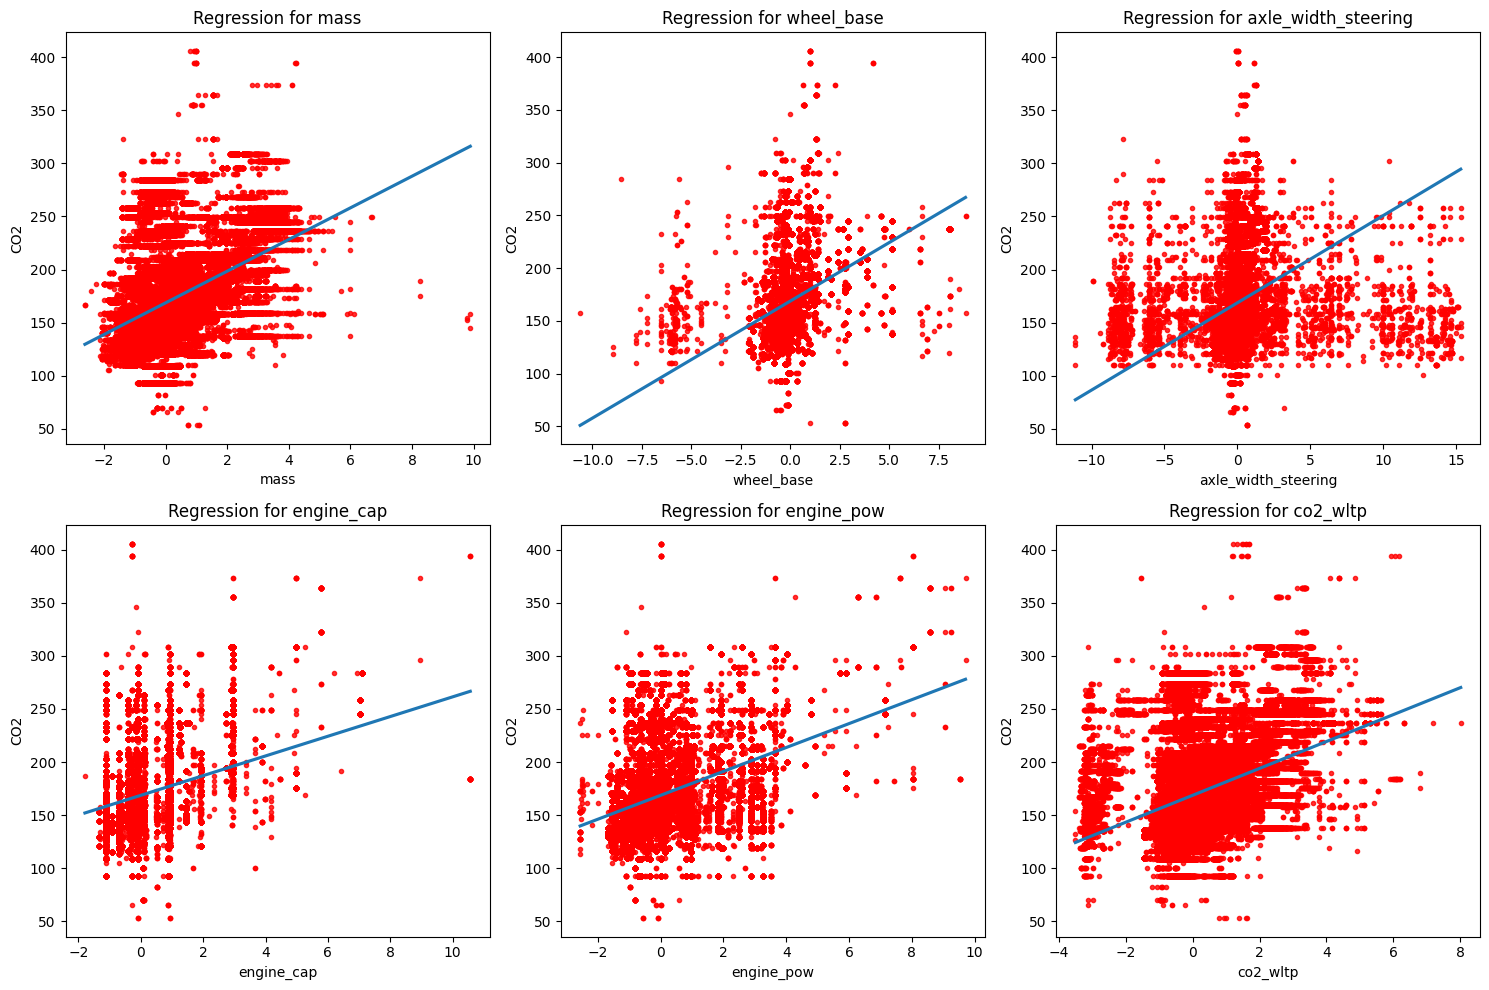

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Regression lines for all training features.
columns_to_plot = dataset.columns[:-1]  
for i, column in enumerate(columns_to_plot):
    row, col = divmod(i, 3)
    g = sns.regplot(x=dataset[column], y=dataset['CO2'], ci=None, scatter_kws={'color': 'r', 's': 9}, ax=axes[row, col])
    g.set_title(f"Regression for {column}")
    g.set_ylabel("CO2")
    g.set_xlabel(column)

for i in range(len(columns_to_plot), 2 * 3):
    row, col = divmod(i, 3)
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

**KNN Regression**

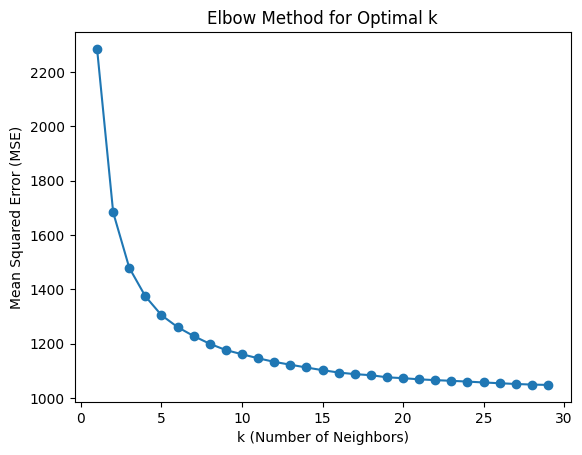

In [29]:
# Elbow Method to decide best k.
k_values = range(1, 30)
mse_values = []

for k in k_values:
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    mse = metrics.mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

plt.plot(k_values, mse_values, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

k = 10 is the best value for the model.

In [30]:
knn_model = KNeighborsRegressor(n_neighbors=10) 
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [31]:
# 0.24 (R²) indicates an average model.
print_errors(y_test, y_pred)

R-squared (R²): 0.24521886140106208
Mean Absolute Error (MAE): 24.123450285708472
Mean Squared Error (MSE): 1161.5132558658747
Root Mean Squared Error (RMSE): 34.0809808524619
MAPE: 13.973681319991845%
Pearson Coefficient: 0.5084468285341853
Spearman Coefficient: 0.47419173765719375


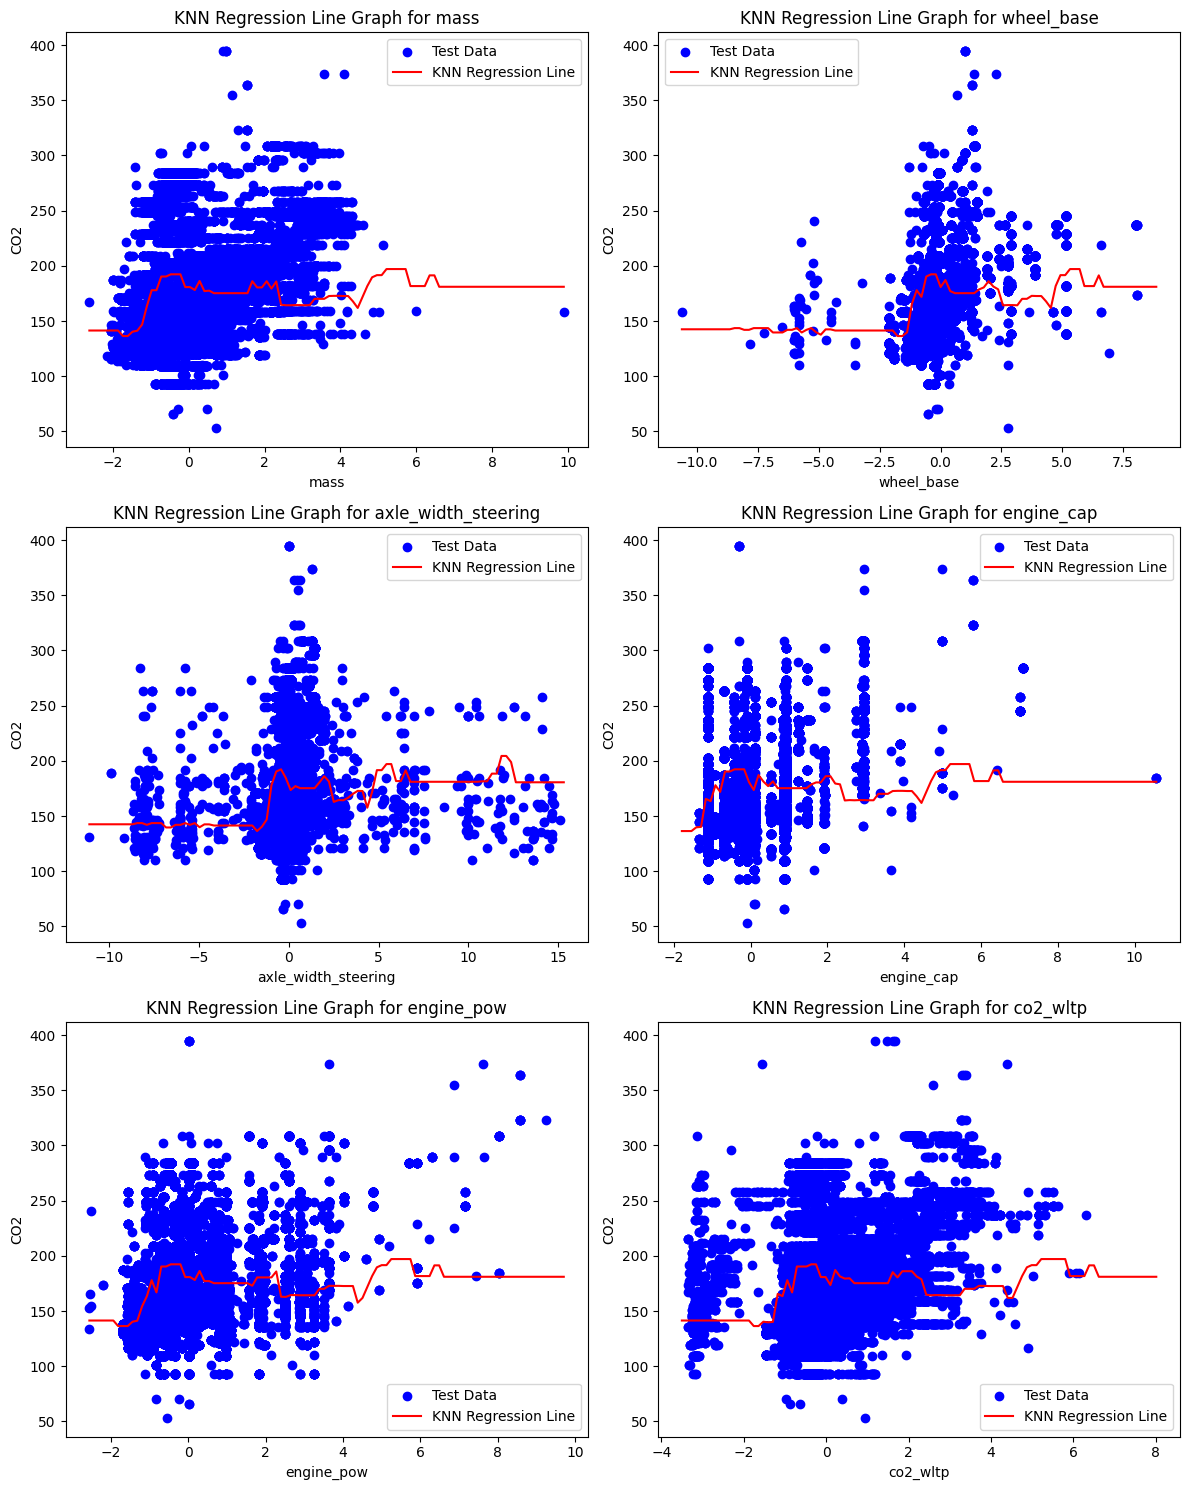

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))

# KNN Regression lines for all training features.
columns_to_plot = dataset.columns[:-1]
for i, column in enumerate(columns_to_plot):
    row, col = divmod(i, 2)
    
    knn_model = KNeighborsRegressor(n_neighbors=10)  
    knn_model.fit(X, y)
    
    feature_range = np.linspace(min(dataset[column]), max(dataset[column]), 100)

    X_range = np.column_stack((feature_range, np.full_like(feature_range, dataset['wheel_base'].mean()),
                               np.full_like(feature_range, dataset['axle_width_steering'].mean()),
                               np.full_like(feature_range, dataset['engine_cap'].mean()),
                               np.full_like(feature_range, dataset['engine_pow'].mean()),
                               np.full_like(feature_range, dataset['co2_wltp'].mean())
                               ))
    y_pred_range = knn_model.predict(X_range)
    
    axes[row, col].scatter(X_test[column], y_test, color='blue', label='Test Data')
    axes[row, col].plot(feature_range, y_pred_range, color='red', label='KNN Regression Line')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('CO2')
    axes[row, col].set_title(f'KNN Regression Line Graph for {column}')
    axes[row, col].legend()

for i in range(len(columns_to_plot), 3 * 2):
    row, col = divmod(i, 2)
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

**Multivariate Regression**

In [33]:
degree = 3
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [34]:
# 0.24 (R²) indicates an average model.
print_errors(y_test, y_pred)

R-squared (R²): 0.23509386719641368
Mean Absolute Error (MAE): 24.556370602364666
Mean Squared Error (MSE): 1177.0943486924582
Root Mean Squared Error (RMSE): 34.30880861662874
MAPE: 14.208214233500271%
Pearson Coefficient: 0.4848671104885017
Spearman Coefficient: 0.4677555217161316


**Ridge Regression**

In [35]:
alpha = 1.0  
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

In [36]:
# 0.18 (R²) indicates an average model.
print_errors(y_test, y_pred)

R-squared (R²): 0.1779705962128152
Mean Absolute Error (MAE): 25.324863018697343
Mean Squared Error (MSE): 1264.9998792798137
Root Mean Squared Error (RMSE): 35.56683679046836
MAPE: 14.607169910709644%
Pearson Coefficient: 0.42189079151044806
Spearman Coefficient: 0.4314749003170477


**Lasso Regression**

In [37]:
alpha = 0.01  # Düzenlileştirme parametresi
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)

In [38]:
# 0.18 (R²) indicates an average model.
print_errors(y_test, y_pred)

R-squared (R²): 0.17796081569344235
Mean Absolute Error (MAE): 25.326222102415432
Mean Squared Error (MSE): 1265.0149302691932
Root Mean Squared Error (RMSE): 35.567048377243694
MAPE: 14.608135052987906%
Pearson Coefficient: 0.4218857091447378
Spearman Coefficient: 0.4315645487905094


**Support Vector Regression**

In [39]:
svr_model = SVR(kernel='linear', C=1.0)
svr_model.fit(X_train, y_train.ravel())
y_pred = svr_model.predict(X_test)

In [41]:
# 0.10 (R²) indicates an average model.
print_errors(y_test, y_pred)

R-squared (R²): 0.06455028815775565
Mean Absolute Error (MAE): 27.249570932784916
Mean Squared Error (MSE): 1439.5394703656266
Root Mean Squared Error (RMSE): 37.94126342605932
MAPE: 15.804541057922242%
Pearson Coefficient: 0.3860286299626734
Spearman Coefficient: 0.35540776326293644


**Decision Tree Regression**

In [42]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

In [43]:
# 0.05 (R²) indicates an average model.
print_errors(y_test, y_pred)

R-squared (R²): 0.06441949417547754
Mean Absolute Error (MAE): 27.253420948270087
Mean Squared Error (MSE): 1439.7407458565397
Root Mean Squared Error (RMSE): 37.94391579498009
MAPE: 15.807684947727404%
Pearson Coefficient: 0.3861471076084663
Spearman Coefficient: 0.3554049036875917


In [44]:
evaluation_data = {
    'Model': ['Linear Regression', 'KNeighbors Regressor', 'Multivariate Regression', 'Ridge Regression', 'Lasso Regression', 'Support Vector Regression', 'Decision Tree Regressor'],
    'R-squared (R²)': [0.1819, 0.2434, 0.2421, 0.1819, 0.1819, 0.1090, 0.0587],
    'Mean Absolute Error': [25.22, 24.14, 24.40, 25.22, 25.22, 23.34, 27.35],
    'Mean Squared Error': [1258.88, 1164.30, 1166.39, 1258.88, 1258.88, 1371.13, 1448.59],
    'Root Mean Squared Error': [35.48, 34.12, 34.15, 35.48, 35.48, 37.03, 38.06],
    'MAPE': ['14.53%', '13.98%', '14.11%', '14.53%', '14.54%', '12.57%', '15.86%'],
    'Pearson Coefficient': [0.4266, 0.5072, 0.4920, 0.4266, 0.4266, 0.4158, 0.3823],
    'Spearman Coefficient': [0.4378, 0.4728, 0.4733, 0.4378, 0.4380, 0.4324, 0.3518]
}

evaluation_table = pd.DataFrame(evaluation_data)
evaluation_table

,Model,R-squared (R²),Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,MAPE,Pearson Coefficient,Spearman Coefficient
0,Linear Regression,0.1819,25.22,1258.88,35.48,14.53%,0.4266,0.4378
1,KNeighbors Regressor,0.2434,24.14,1164.30,34.12,13.98%,0.5072,0.4728
2,Multivariate Regression,0.2421,24.40,1166.39,34.15,14.11%,0.4920,0.4733
3,Ridge Regression,0.1819,25.22,1258.88,35.48,14.53%,0.4266,0.4378
4,Lasso Regression,0.1819,25.22,1258.88,35.48,14.54%,0.4266,0.4380
5,Support Vector Regression,0.1090,23.34,1371.13,37.03,12.57%,0.4158,0.4324
6,Decision Tree Regressor,0.0587,27.35,1448.59,38.06,15.86%,0.3823,0.3518


R-squared (R²): This value indicates how well the model fits the data. The highest R-squared value is observed in the KNeighbors Regressor model.

Mean Absolute Error (MAE): MAE measures how close the model's predictions are to the actual values. The lowest MAE value is observed in the SVR (Support Vector Regression) model.

Mean Squared Error (MSE): MSE is the average of the squared errors. A low MSE indicates better model performance. The lowest MSE value is observed in the KNeighbors Regressor model.

Root Mean Squared Error (RMSE): RMSE is the square root of MSE and helps express errors in the original measurement unit. The lowest RMSE value is observed in the KNeighbors Regressor model.

MAPE (Mean Absolute Percentage Error): MAPE calculates the average percentage of errors. A lower MAPE indicates better prediction performance. The lowest MAPE value is observed in the SVR model.

Pearson and Spearman Coefficients: These coefficients measure the relationship between two variables. The highest Pearson and Spearman coefficients are observed in the KNeighbors Regressor model.

In general, the model that seems to best fit your data is the KNeighbors Regressor. It has the highest R-squared value, lowest MSE, lowest RMSE, and highest Pearson and Spearman coefficients, suggesting a strong relationship between predicted and actual values.

In [45]:
evaluation_table.to_csv('model_evaluations.csv')

In [47]:
models = ['Linear Regression', 
          'KNeighbors Regressor', 
          'Multivariate Regression', 
          'Ridge Regression', 
          'Lasso Regression', 
          'Support Vector Regression', 
          'Decision Tree Regressor']

rmse_errors = [35.48, 
               34.12, 
               34.15, 
               35.48, 
               35.48, 
               37.03, 
               38.06]

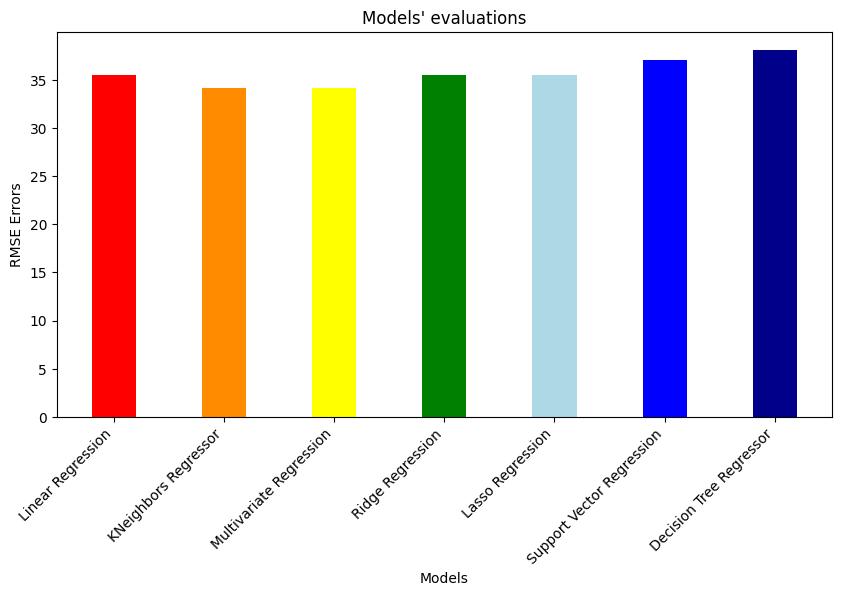

In [56]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(models, rmse_errors, color =['red', 'darkorange', 'yellow', 'green', 'lightblue', 'blue', 'darkblue', 'purple'], 
        width = 0.4)
 
plt.xlabel("Models")
plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE Errors")
plt.title("Models' evaluations")
plt.show()